<a href="https://colab.research.google.com/github/manumeehl/trajectories/blob/main/Trajectories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!apt install tesseract-ocr
!pip install opencv-python-headless pytesseract pytube

In [22]:
from google.colab.patches import cv2_imshow as show
from pytesseract import image_to_string as img_to_str
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from pytube import YouTube
import pandas as pd
import numpy as np
import pytesseract
import math
import cv2
import re

In [ ]:
''' Video Tools '''
def get_video(url, path):
  vid = YouTube(url)
  print(f"Downloading Video '{vid.streams[0].title}'")
  vid.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first().download(output_path=path, filename='launch.mp4')
  print('Download complete')

def show_frame(vid, position):
  vid.set(cv2.CAP_PROP_POS_FRAMES, int(position))
  ret, frame = vid.read()
  show(frame)

In [ ]:
''' Conversion tools '''
def clock_to_secs(clockstring):
  ''' Convert a mission clock string to an integer second value '''
  tense = -1 if clockstring[:2] == 't-' else 1
  # Remove the T+- sign
  clockstring = clockstring [2:]
  # Get the seconds
  units = clockstring.split(':')
  hours = int(units[0])
  minutes = int(units[1])
  seconds = int(units[2])

  return hours * 3600 + minutes * 60 + seconds

def frame_to_elapsed(framepos):
  # Calculate the exact time since liftoff based on the current frame
  return  round((framepos - liftoff_frame) / fps, 2)

In [24]:
''' OCR parsing '''
def parse_clock(string):
  ''' Extract mission clock, altitude and velocity from a given string '''
  string = string.lower()

  # Find the mission clock (T+00:00:00)
  mission_clock = re.findall(r't[+-]\d{2}:\d{2}:\d{2}', string)
  if mission_clock: return mission_clock[0]
  else: return None

def parse_trajectory(string):
  ''' Extract altitude and velocity from a given string '''
  string = string.lower()
  output = []

  # Apply a blacklist
  blacklist = ['stage 1', 'stage 2', 'falcon 9', 'starlink']
  for w in blacklist:
    string = string.replace(w, '')

  # Find all numbers and floats in the string
  numbers = re.findall(r'\d+(?:\.\d+)?', string)
  numbers = list(set([float(x) for x in numbers]))
  # Check if there are exactly two numbers
  if len(numbers) == 2:
    output =  [min(numbers), max(numbers)]
  return output

In [40]:
def preprocess(frame):
  ''' Apply preprocessing filters to a frame '''
  return cv2.bitwise_not(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

def get_snippets(frame):
  ''' Cut out regions of interest and apply filters for OCR '''
  height, width, _ = frame.shape

  stage1 = preprocess(frame[height-80:height-40,50:300])
  stage2 = preprocess(frame[height-80:height-40,width-300:width-50])
  clock = preprocess(frame[height-110:height-20,int(width/2-200):int(width/2+200)])

  return clock, stage1, stage2

def extract_data(frame):
  ''' Pre-process frames and extract the data '''
  clockframe, stage1, stage2 = get_snippets(frame)
  ocr_config = '--psm 11'

  clock = parse_clock(img_to_str(clockframe, config=ocr_config))
  trajectory_s1 = parse_trajectory(img_to_str(stage1, config=ocr_config))
  trajectory_s2 = []
  # trajectory_s2 = parse_trajectory(img_to_str(stage2, config=ocr_config))

  return {
      'Clock': clock,
      'Stage 1': trajectory_s1,
      'Stage 2': trajectory_s2
  }

In [26]:
def await_liftoff():
  ''' Identify the frame at which liftoff occurs '''
  framepos = 0
  # Look for the clock every 2 minutes
  interval = int(30 * fps)
  clock = ''
  # Await first mission clock appearance
  while vid.isOpened():
    vid.set(cv2.CAP_PROP_POS_FRAMES, int(framepos))
    framepos += interval

    ret, frame = vid.read()
    data = extract_data(frame)

    if 'Clock' in data.keys():
      clock = data['Clock']
      break

  # Now wait until the next full second
  interval = 2
  while vid.isOpened():
    vid.set(cv2.CAP_PROP_POS_FRAMES, int(framepos))
    framepos += interval

    ret, frame = vid.read()
    data = extract_data(frame)

    if 'Clock' in data.keys() and data['Clock'] != clock:
      framepos += int(clock_to_secs(data['Clock']) * fps)
      return framepos


In [41]:
''' Fetch the trajectory via OCR '''
def process_launch(vid, liftoff_frame):
  framepos = liftoff_frame
  trajectory = pd.DataFrame(columns = ['Clock', 'Elapsed', 'Altitude', 'Velocity'])

  while vid.isOpened():
    vid.set(cv2.CAP_PROP_POS_FRAMES, int(framepos))
    ret, frame = vid.read()
    data = extract_data(frame)

    if 'Clock' in data.keys() and len(data['Stage 1']) == 2:
      # Save data
      print(data)
      data['Elapsed'] = round((framepos - liftoff_frame) / fps, 1)
      trajectory.loc[len(trajectory)] = [data['Clock'], data['Stage 1'][0], data['Stage 1'][1]]
      # Skip to next second
      framepos += int(fps - ((framepos - liftoff_frame) % fps)) + 3
    else:
      framepos += 5
    if framepos > liftoff_frame + (10*fps):
      break

  return trajectory


In [ ]:
# Fetch file from youtube
url = 'https://www.youtube.com/watch?v=agYuEAkEljw'
get_video(url, 'launches')

Download complete


In [ ]:
# Fetch local file
vidpath = 'launches/launch.mp4'
vid = cv2.VideoCapture(vidpath)
fps = vid.get(cv2.CAP_PROP_FPS)

print('Awaiting liftoff')
liftoff_frame = await_liftoff()

# Show liftoff frame
#show_frame(vid, liftoff_frame)

Awaiting liftoff


In [39]:
print('Liftoff registered, now monitoring launch')
trajectory = process_launch(vid, liftoff_frame)

Liftoff registered, now monitoring launch
{'Clock': 't+00:00:00', 'Stage 1': [], 'Stage 2': {}}


ValueError: ignored

In [36]:
''' Data Post-Processing '''
def smooth_curve(curve):
  ''' Correct decimal errors of the OCR algorithm '''
  for i in range(len(curve[1:])):
    # Avoid zero-divisions
    if curve[i] == 0: curve[i] = 0.1
    # Apply outlier correction
    if curve[i+1] / curve[i] > 100:
      curve[i+1] /= 100
    elif curve[i+1] / curve[i] > 2:
      curve[i+1] /= 10
    elif curve[i+1] / curve[i] < 0.5:
      curve[i+1] *= 10
  return curve

def interpolate_curve(x, y):
    x = [math.floor(i) for i in x]
    # Double the number of data points
    x_smooth = np.linspace(x[0], x[-1], len(x) * 2)

    # Use cubic spline interpolation to generate smooth y values
    f = interp1d(x, y, kind='quadratic')
    y_smooth = f(x_smooth)

    return x_smooth, y_smooth

trajectory['Altitude (corrected)'] = smooth_curve(trajectory['Altitude'].values.tolist())
trajectory['Velocity (corrected)'] = smooth_curve(trajectory['Velocity'].values.tolist())
trajectory.to_csv('trajectory.csv')

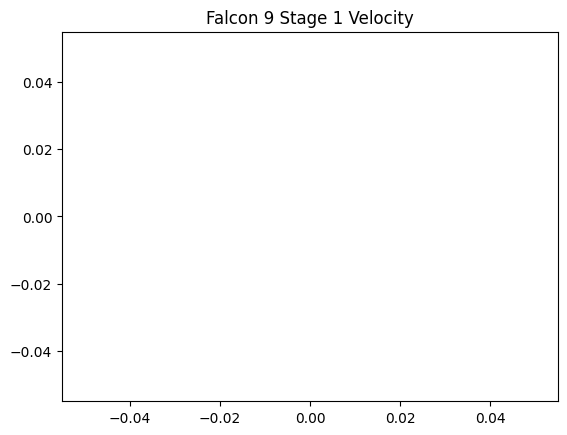

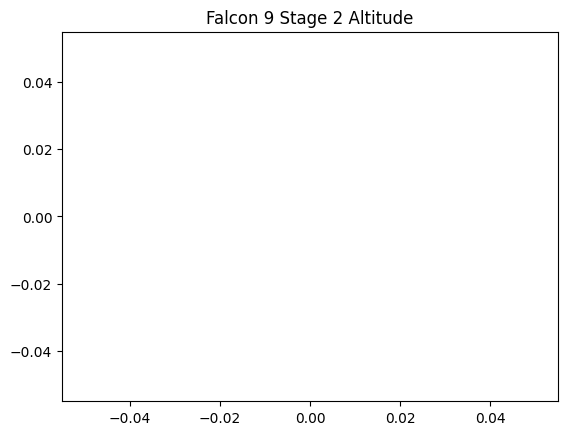

In [37]:
''' Data plots '''
#trajectory = pd.read_csv('trajectory.csv')
clock = trajectory['Elapsed'].values.tolist()

altitude = trajectory['Altitude (corrected)'].values.tolist()
velocity = trajectory['Velocity (corrected)'].values.tolist()

plt.title('Falcon 9 Stage 1 Velocity')
plt.plot(clock, velocity)
plt.show()

plt.title('Falcon 9 Stage 2 Altitude')
plt.plot(clock, altitude)
plt.show()